In [ ]:
!pip install pysiology

In [ ]:
from google.colab import files
files.upload()

In [3]:
#@title Fix
import os,shutil
os.remove("/usr/local/lib/python3.10/dist-packages/pysiology/electromyography.py")
shutil.move("/content/electromyography.py","/usr/local/lib/python3.10/dist-packages/pysiology/electromyography.py")

'/usr/local/lib/python3.10/dist-packages/pysiology/electromyography.py'

In [ ]:
! wget -r -N -c -np https://physionet.org/files/gaitndd/1.0.0/

In [5]:
import pysiology
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os,shutil

Thank you for using Pysiology. If you use it in your work, please cite:
Gabrieli G., Azhari A., Esposito G. (2020) PySiology: A Python Package for Physiological Feature Extraction. In: Esposito A., Faundez-Zanuy M., Morabito F., Pasero E. (eds) Neural Approaches to Dynamics of Signal Exchanges. Smart Innovation, Systems and Technologies, vol 151. Springer, Singapore. https://doi.org/10.1007/978-981-13-8950-4_35


In [6]:
#EDA
from collections import Counter
# data preprocessing
from sklearn.preprocessing import StandardScaler
# data splitting
from sklearn.model_selection import train_test_split
# data modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
# from mlxtend.classifier import StackingCVClassifier

In [ ]:
data_1 = pd.read_csv("physionet.org/files/gaitndd/1.0.0/als1.ts",delimiter="\t",names=["Elapsed Time (sec)","Left Stride Interval (sec)","Right Stride Interval (sec)","Left Swing Interval (sec)",
                                                      "Right Swing Interval (sec)","Left Swing Interval (% of stride)","Right Swing Interval (% of stride)",
                                                      "Left Stance Interval (sec)","Right Stance Interval (sec)","Left Stance Interval (% of stride)",
                                                      "Right Stance Interval (% of stride)","Double Support Interval (sec)","Double Support Interval (% of stride)"])

data_1.head()

,Elapsed Time (sec),Left Stride Interval (sec),Right Stride Interval (sec),Left Swing Interval (sec),Right Swing Interval (sec),Left Swing Interval (% of stride),Right Swing Interval (% of stride),Left Stance Interval (sec),Right Stance Interval (sec),Left Stance Interval (% of stride),Right Stance Interval (% of stride),Double Support Interval (sec),Double Support Interval (% of stride)
0,22.3200,1.2833,1.3533,0.4067,0.4133,31.69,30.54,0.8767,0.9400,68.31,69.46,0.4633,36.10
1,23.6433,1.3233,1.2667,0.4833,0.4000,36.52,31.58,0.8400,0.8667,63.48,68.42,0.4400,33.25
2,24.9467,1.3033,1.3600,0.4500,0.4267,34.53,31.37,0.8533,0.9333,65.47,68.63,0.4267,32.74
3,26.3633,1.4167,1.2833,0.5033,0.3667,35.53,28.57,0.9133,0.9167,64.47,71.43,0.5467,38.59
4,27.6000,1.2367,1.4067,0.3467,0.3567,28.03,25.36,0.8900,1.0500,71.97,74.64,0.5333,43.13


In [ ]:
dataset_path = "physionet.org/files/gaitndd/1.0.0"
dict_data = {'MNF': [], 'MDF': [],'PeakFrequency': [], 'MNP': [],'TTP': [], 'SM1': [],'SM2': [], 'SM3': []
  ,'FR': [], 'PSR': [], 'VCF': [],'IEMG': [], 'MAV': [], 'MAV1': [], 
 'MAV2': [], 'SSI': [], 'VAR': [], 'TM3': [], 'TM4': [], 'TM5': [],  
 'LOG': [], 'RMS': [], 'WL': [], 'AAC': [], 'DASDV': [], 'ZC': [], 'MYOP':[],   
 'WAMP': [], 'SSC': [], 'MAVSLPk1':[],"MAVSLPk2":[],"MAVSLPk3":[],"label":[]}
  
folders = [os.path.join(dataset_path, folder_name) for folder_name in os.listdir(dataset_path) if str(folder_name).endswith(".ts")]  
  
labels = ["als","control","hunt","park"]
for folder in folders:  
  if(re.split("\d", str(folder.split("/")[4]))[0] != "example"):
    df = pd.read_csv(folder,delimiter="\t",names=["Elapsed Time (sec)","Left Stride Interval (sec)","Right Stride Interval (sec)","Left Swing Interval (sec)",  
                                                      "Right Swing Interval (sec)","Left Swing Interval (% of stride)","Right Swing Interval (% of stride)",  
                                                      "Left Stance Interval (sec)","Right Stance Interval (sec)","Left Stance Interval (% of stride)",  
                                                      "Right Stance Interval (% of stride)","Double Support Interval (sec)","Double Support Interval (% of stride)"])
    target = ["Left Stride Interval (sec)","Right Stride Interval (sec)","Left Swing Interval (sec)","Right Swing Interval (sec)",
              "Left Stance Interval (sec)","Right Stance Interval (sec)","Double Support Interval (sec)"] 
    label = labels.index(re.split("\d", str(folder.split("/")[4]))[0]) 
    for f in target:
      data = df[f]
      analyzedEMG = pysiology.electromyography.analyzeEMGnew(data,samplerate=200,preprocessing=False) 
      time,freq = analyzedEMG

      freq = analyzedEMG[freq]
      keys1 = list(freq.keys())

      for i in keys1 :
        dict_data[i].append(freq[i])

      time = analyzedEMG[time]
      keys2 = list(time.keys())[:-1]

      for i in keys2 :
        dict_data[i].append(time[i])

      dict_data["MAVSLPk1"].append(time["MAVSLPk"][0])
      dict_data["MAVSLPk2"].append(time["MAVSLPk"][1])
      dict_data["MAVSLPk3"].append(time["MAVSLPk"][2])
      dict_data["label"].append(label)

dataFrame = pd.DataFrame(dict_data)

In [ ]:
dataFrame

,MNF,MDF,PeakFrequency,MNP,TTP,SM1,SM2,SM3,FR,PSR,...,AAC,DASDV,ZC,MYOP,WAMP,SSC,MAVSLPk1,MAVSLPk2,MAVSLPk3,label
0,26.414111,9.090909,2.272727,0.000194,0.017275,0.456292,0.000128,1.248511e-07,inf,1.331553,...,0.074282,0.010618,0,1.0,80,111,1.562645,1.588852,1.574938,0
1,25.637906,9.090909,2.272727,0.000198,0.017618,0.451680,0.000139,1.350036e-07,inf,1.299170,...,0.075019,0.011644,0,1.0,74,114,1.560234,1.590576,1.574890,0
2,42.680963,37.500000,32.954545,0.000042,0.003772,0.160988,0.000014,1.960589e-09,inf,0.636882,...,0.037288,0.002732,0,1.0,73,104,0.468162,0.451778,0.443912,0
3,47.045589,51.136364,63.636364,0.000023,0.002039,0.095927,0.000005,3.213156e-10,inf,0.450526,...,0.040584,0.002692,0,1.0,71,111,0.428507,0.424372,0.421145,0
4,30.149058,12.500000,2.272727,0.000142,0.012665,0.381851,0.000073,4.050992e-08,inf,1.065660,...,0.065205,0.009194,0,1.0,78,101,1.094490,1.137069,1.131031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,55.451770,54.761905,35.714286,0.000164,0.020845,1.155894,0.000436,2.401635e-07,inf,0.511806,...,0.139284,0.031208,0,1.0,118,172,0.378855,0.337063,0.337661,2
444,51.282509,53.174603,56.349206,0.000309,0.039213,2.010941,0.001083,7.623757e-07,inf,0.536625,...,0.164041,0.048800,0,1.0,119,162,0.383015,0.419761,0.397535,2
445,40.185198,35.714286,0.793651,0.001516,0.192584,7.739040,0.016931,4.983106e-05,inf,0.383628,...,0.254471,0.169057,0,1.0,127,171,0.687817,0.769964,0.808815,2
446,51.056457,53.174603,89.682540,0.001516,0.192509,9.828812,0.026825,1.054169e-04,inf,0.365854,...,0.236085,0.210265,0,1.0,130,168,0.680832,0.695283,0.750319,2


In [ ]:
dataFrame.iloc[:60,:16]

,MNF,MDF,PeakFrequency,MNP,TTP,SM1,SM2,SM3,FR,PSR,VCF,IEMG,MAV,MAV1,MAV2,SSI
0,26.414111,9.090909,2.272727,0.000194,0.017275,0.456292,1.276331e-04,1.248511e-07,inf,1.331553,-697.697892,277.3332,1.575757,1.180549,0.787662,438.841857
1,25.637906,9.090909,2.272727,0.000198,0.017618,0.451680,1.386135e-04,1.350036e-07,inf,1.299170,-657.294366,277.1939,1.574965,1.179926,0.788542,438.491809
2,42.680963,37.500000,32.954545,0.000042,0.003772,0.160988,1.350568e-05,1.960589e-09,inf,0.636882,-1821.661021,79.9234,0.454110,0.339810,0.231109,36.605856
3,47.045589,51.136364,63.636364,0.000023,0.002039,0.095927,4.572141e-06,3.213156e-10,inf,0.450526,-2213.285224,74.8001,0.425001,0.319073,0.217844,32.064392
4,30.149058,12.500000,2.272727,0.000142,0.012665,0.381851,7.288136e-05,4.050992e-08,inf,1.065660,-908.959926,197.4102,1.121649,0.840740,0.556552,223.157187
5,24.999389,9.090909,2.272727,0.000213,0.018975,0.474369,1.437275e-04,1.708104e-07,inf,1.385269,-624.961862,202.3930,1.149960,0.860849,0.570697,234.788490
6,29.704060,18.181818,2.272727,0.000170,0.015161,0.450341,9.051236e-05,6.132152e-08,inf,1.001539,-882.325229,122.6098,0.696647,0.521666,0.338706,87.517654
7,31.580781,21.093750,7.031250,0.000115,0.014813,0.467818,6.129293e-05,1.719499e-08,inf,0.870397,-997.341560,278.0069,1.085964,0.817071,0.548801,303.222318
8,35.059948,27.343750,7.031250,0.000045,0.005757,0.201843,1.065720e-05,1.183376e-09,inf,0.763208,-1229.198133,276.9598,1.081874,0.812917,0.544893,300.360944
9,34.295834,24.218750,1.562500,0.000004,0.000492,0.016875,8.184429e-08,6.727875e-13,inf,0.786098,-1176.204070,104.6492,0.408786,0.307205,0.207107,42.839474


In [ ]:
dataFrame.iloc[:60,16:]

,VAR,TM3,TM4,TM5,LOG,RMS,WL,AAC,DASDV,ZC,MYOP,WAMP,SSC,MAVSLPk1,MAVSLPk2,MAVSLPk3,label
0,2.507668,3.964032,6.335406,10.186276,4.834399,1.579057,13.0737,0.074282,0.010618,0,1.0,80,111,1.562645,1.588852,1.574938,0
1,2.505667,3.960938,6.333516,10.195034,4.830574,1.578427,13.2033,0.075019,0.011644,0,1.0,74,114,1.560234,1.590576,1.574890,0
2,0.209176,0.096140,0.044893,0.021207,1.574772,0.456057,6.5626,0.037288,0.002732,0,1.0,73,104,0.468162,0.451778,0.443912,0
3,0.183225,0.078719,0.034267,0.015022,1.529591,0.426830,7.1427,0.040584,0.002692,0,1.0,71,111,0.428507,0.424372,0.421145,0
4,1.275184,1.447006,1.670928,1.958099,3.069912,1.126028,11.4761,0.065205,0.009194,0,1.0,78,101,1.094490,1.137069,1.131031,0
5,1.341649,1.563767,1.856229,2.237109,3.158067,1.155000,12.3934,0.070417,0.010500,0,1.0,76,107,1.131728,1.166200,1.153734,0
6,0.500101,0.367343,0.285067,0.236919,2.007011,0.705166,11.4600,0.065114,0.010290,0,1.0,77,97,0.665976,0.712698,0.709886,0
7,1.189107,1.299657,1.438332,1.611976,2.962295,1.088330,8.6496,0.033787,0.005189,0,1.0,98,143,1.055886,1.110586,1.091806,2
8,1.177886,1.275755,1.391143,1.521733,2.950204,1.083183,8.6606,0.033830,0.002984,0,1.0,109,146,1.055761,1.098080,1.092078,2
9,0.167998,0.068604,0.028169,0.011585,1.504990,0.409074,3.5559,0.013890,0.000344,0,1.0,77,149,0.405844,0.413800,0.406739,2


In [ ]:
dataFrame.columns

Index(['MNF', 'MDF', 'PeakFrequency', 'MNP', 'TTP', 'SM1', 'SM2', 'SM3', 'FR',
       'PSR', 'VCF', 'IEMG', 'MAV', 'MAV1', 'MAV2', 'SSI', 'VAR', 'TM3', 'TM4',
       'TM5', 'LOG', 'RMS', 'WL', 'AAC', 'DASDV', 'ZC', 'MYOP', 'WAMP', 'SSC',
       'MAVSLPk1', 'MAVSLPk2', 'MAVSLPk3', 'label'],
      dtype='object')

In [8]:
dataFrame =  dataFrame.drop(columns='FR')
dataFrame =  dataFrame.drop(columns='ZC')
dataFrame =  dataFrame.drop(columns='MYOP')

In [ ]:
# !pip -q install dataprep

In [ ]:

# from dataprep.eda import plot, plot_correlation, plot_missing,create_db_report,create_report
# report = create_report(dataFrame)
# report

In [ ]:
dataFrame["label"].unique()

array([0, 2, 3, 1])

In [ ]:
  als = dataFrame[dataFrame.label == 0]
  control = dataFrame[dataFrame.label==1]
  hunt = dataFrame[dataFrame.label==2]
  park = dataFrame[dataFrame.label==3]

In [ ]:
def plot_scatter(x,y):
  fig, ax = plt.subplots()
  fig.set_size_inches(13, 7) 
  # lables and scatter points
  ax.scatter(als[x], als[y], label="als", facecolor="blue")
  ax.scatter(control[x], control[y], label="control", facecolor="green")
  ax.scatter(hunt[x], hunt[y], label="hunt", facecolor="red")
  ax.scatter(park[x], park[y], label="park", facecolor="Yellow")
  ax.set_xlabel(x)
  ax.set_ylabel(y)
  ax.grid()
  ax.set_title("")
  ax.legend()

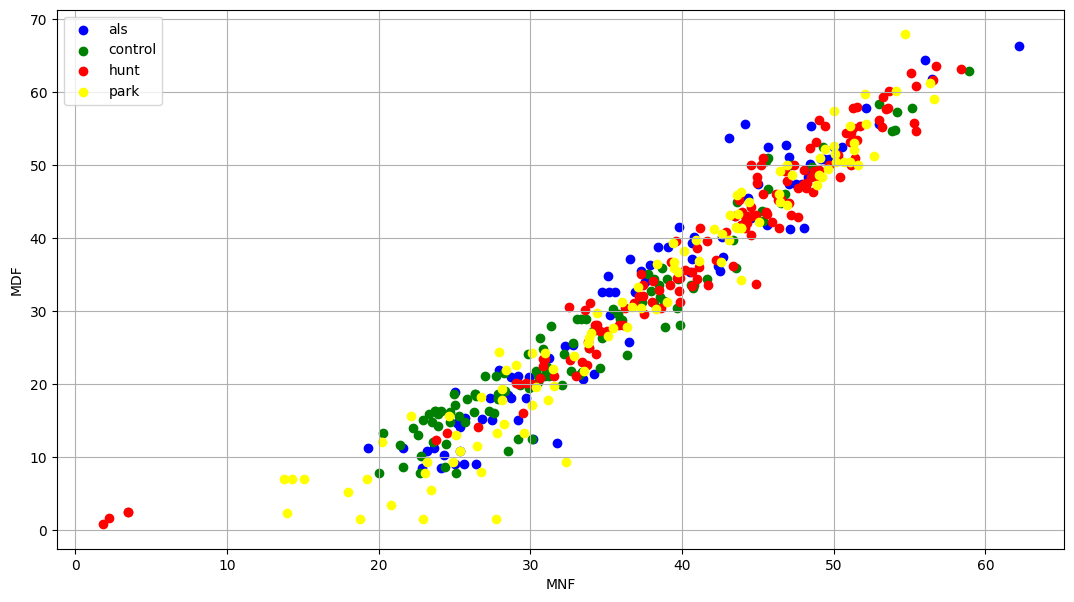

In [ ]:
plot_scatter('MNF', 'MDF')

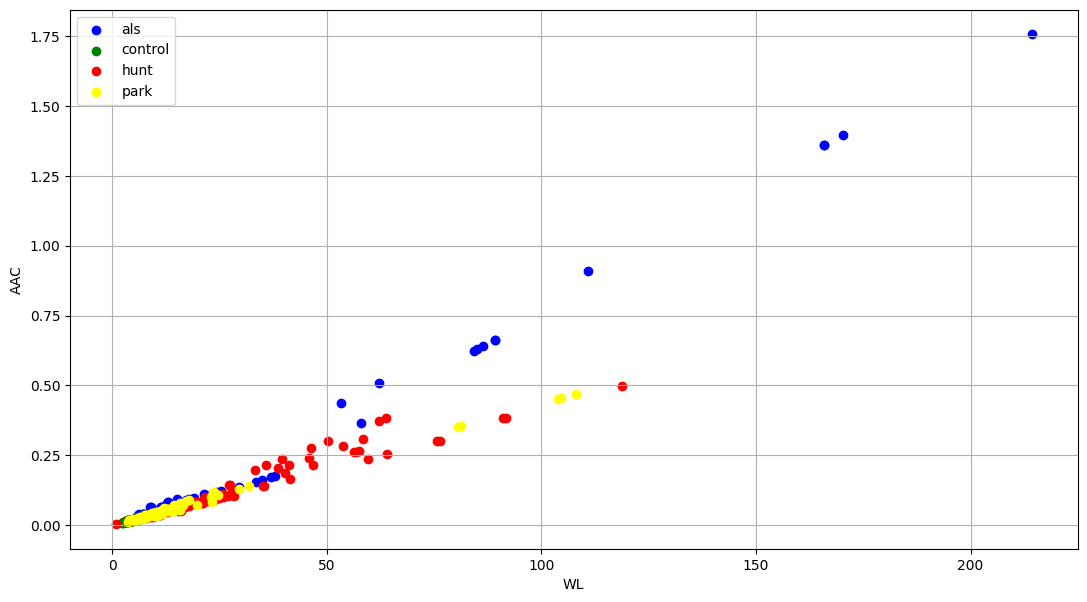

In [ ]:
plot_scatter('WL', 'AAC')

In [ ]:
# plt.figure(figsize=(50,50))
# sns.heatmap(dataFrame.corr())

# Main function

In [9]:
def Main(dataFrame,columns):
    models = {
        'Logistic Regression':LogisticRegression(max_iter=5000,solver='lbfgs', fit_intercept=True,intercept_scaling=1),
        "Naive Bayes":GaussianNB( var_smoothing=1e-018),
        'Support Vector ':SVC(kernel='rbf', C=2, max_iter=-1),
        "Decision Tree":DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 32),
        "Random Forest": RandomForestClassifier(n_estimators=26, random_state=2,max_depth=5),
        "K-Neighbors":KNeighborsClassifier(n_neighbors=16),
        "Extreme Gradient Boost":XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5),
        "Ada Boost":AdaBoostClassifier(n_estimators=500, learning_rate = 0.75),
        "LDA":LinearDiscriminantAnalysis(),
        "MLP":MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,solver='sgd',  random_state=21,tol=0.000000001)
    }
    acc_score={}
    colors = ['red','green','blue','Cyan','Lime','yellow','orange',"DeepPink","OrangeRed","DarkMagenta"]
    y, X = dataFrame['label'], dataFrame.loc[:,columns].astype('float64')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    score = []
    models_names = list(models.keys())
    for i in models_names:
      models[i].fit(X_train, y_train)
      predict = models[i].predict(X_test)
      acc = accuracy_score(y_test, predict)
      score.append(acc*100)
    acc_score["Model"] = models_names
    acc_score["Accuracy"] = score
    frame =  pd.DataFrame(acc_score)
    plt.figure(figsize=(20,10))
    plt.title("barplot Represent Accuracy of different models")
    plt.xlabel("Algorithms")
    plt.ylabel("Accuracy %")
    plt.bar(frame['Model'],frame['Accuracy'],color = colors)
    plt.show()
    return [frame,models.copy()]

In [ ]:
def filter(dataFrame,name):
    mean = dataFrame[name].mean().astype('float64')
    std = dataFrame[name].std().astype('float64')
    data = dataFrame.loc[:,[name,'label']].astype('float64')
    for x in data.index:
      if data.loc[x, name] > mean+std or data.loc[x, name] < mean-std:
        data.drop(x, inplace = True)
    return data

def MainoneByone(dataFrame):
    models = {
        'Logistic Regression':LogisticRegression(max_iter=5000,solver='lbfgs', fit_intercept=True,intercept_scaling=1),
        "Naive Bayes":GaussianNB( var_smoothing=1e-018),
        'Support Vector ':SVC(kernel='rbf', C=2, max_iter=-1),
        "Decision Tree":DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 32),
        "Random Forest": RandomForestClassifier(n_estimators=26, random_state=2,max_depth=5),
        "K-Neighbors":KNeighborsClassifier(n_neighbors=16),
        "Extreme Gradient Boost":XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5),
        "Ada Boost":AdaBoostClassifier(n_estimators=500, learning_rate = 0.75),
        "LDA":LinearDiscriminantAnalysis(),
        "MLP":MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,solver='sgd',  random_state=21,tol=0.000000001)
    }
    columns = list(dataFrame.columns)
    data={  
        "feature":[],
        'Logistic Regression':[],  
        "Naive Bayes":[],
        'Support Vector ':[],   
        "Decision Tree":[],
        "Random Forest": [],  
        "K-Neighbors":[],
        "Extreme Gradient Boost":[],    
        "Ada Boost":[],
        "LDA":[], 
        "MLP":[],   
    }  
    reject =[]
    models_names = list(models.keys())  
    for j in columns[:-1]:  
      copy_model = models.copy()  
      # filter 

      df =  filter(dataFrame,j) 
      
      if (len(df.index) > 100):
        y, X = df['label'], df[[j]].astype('float64') 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   
        for i in models_names: 
            copy_model[i].fit(X_train, y_train)      
            predict = copy_model[i].predict(X_test)   
            acc = accuracy_score(y_test, predict)     
            data[i].append(acc*100)  
        data["feature"].append(j)   
      else: 
        reject.append(j)
    frame =  pd.DataFrame(data)  
    return [frame,reject]  

[acuuracy,rejected] = MainoneByone(dataFrame)

In [12]:
acuuracy

,feature,Logistic Regression,Naive Bayes,Support Vector,Decision Tree,Random Forest,K-Neighbors,Extreme Gradient Boost,Ada Boost,LDA,MLP
0,MNF,42.105263,42.105263,36.842105,31.578947,35.087719,31.578947,29.824561,29.824561,42.105263,40.350877
1,MDF,37.037037,40.740741,37.037037,50.000000,40.740741,27.777778,35.185185,38.888889,37.037037,33.333333
2,PeakFrequency,28.947368,32.894737,32.894737,69.736842,61.842105,40.789474,59.210526,48.684211,31.578947,32.894737
3,MNP,21.348315,35.955056,24.719101,35.955056,46.067416,42.696629,42.696629,40.449438,23.595506,21.348315
4,TTP,31.111111,31.111111,34.444444,37.777778,53.333333,50.000000,46.666667,42.222222,31.111111,31.111111
5,SM1,50.000000,46.590909,30.681818,42.045455,47.727273,48.863636,48.863636,44.318182,29.545455,50.000000
6,SM2,28.888889,27.777778,34.444444,44.444444,48.888889,44.444444,43.333333,42.222222,28.888889,31.111111
7,SM3,30.000000,28.888889,31.111111,32.222222,33.333333,47.777778,43.333333,30.000000,28.888889,28.888889
8,PSR,37.078652,38.202247,38.202247,28.089888,34.831461,37.078652,35.955056,32.584270,33.707865,38.202247
9,VCF,40.000000,36.363636,40.000000,29.090909,29.090909,30.909091,36.363636,34.545455,40.000000,40.000000


In [13]:
rejected

[]

In [ ]:
# for i in rejected:
#   dataFrame =  dataFrame.drop(columns=i)

# filter and concatenate multi column 

In [16]:
def filtermultiColumn(dataFrame,selected_features):
  std={}
  mean={}
  for i in selected_features:
    mean[i] = dataFrame[i].mean().astype('float64')
    std[i] =dataFrame[i].std().astype('float64')
  selected_features.append("label")
  df = dataFrame[selected_features]
  for i in selected_features[:-1]:
    for j in df[i].index:
      if df.loc[j, i] > mean[i]+std[i] or df.loc[j, i] < mean[i]-std[i]:
        df = df.drop(j)
  return df

## train on all filtered data


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


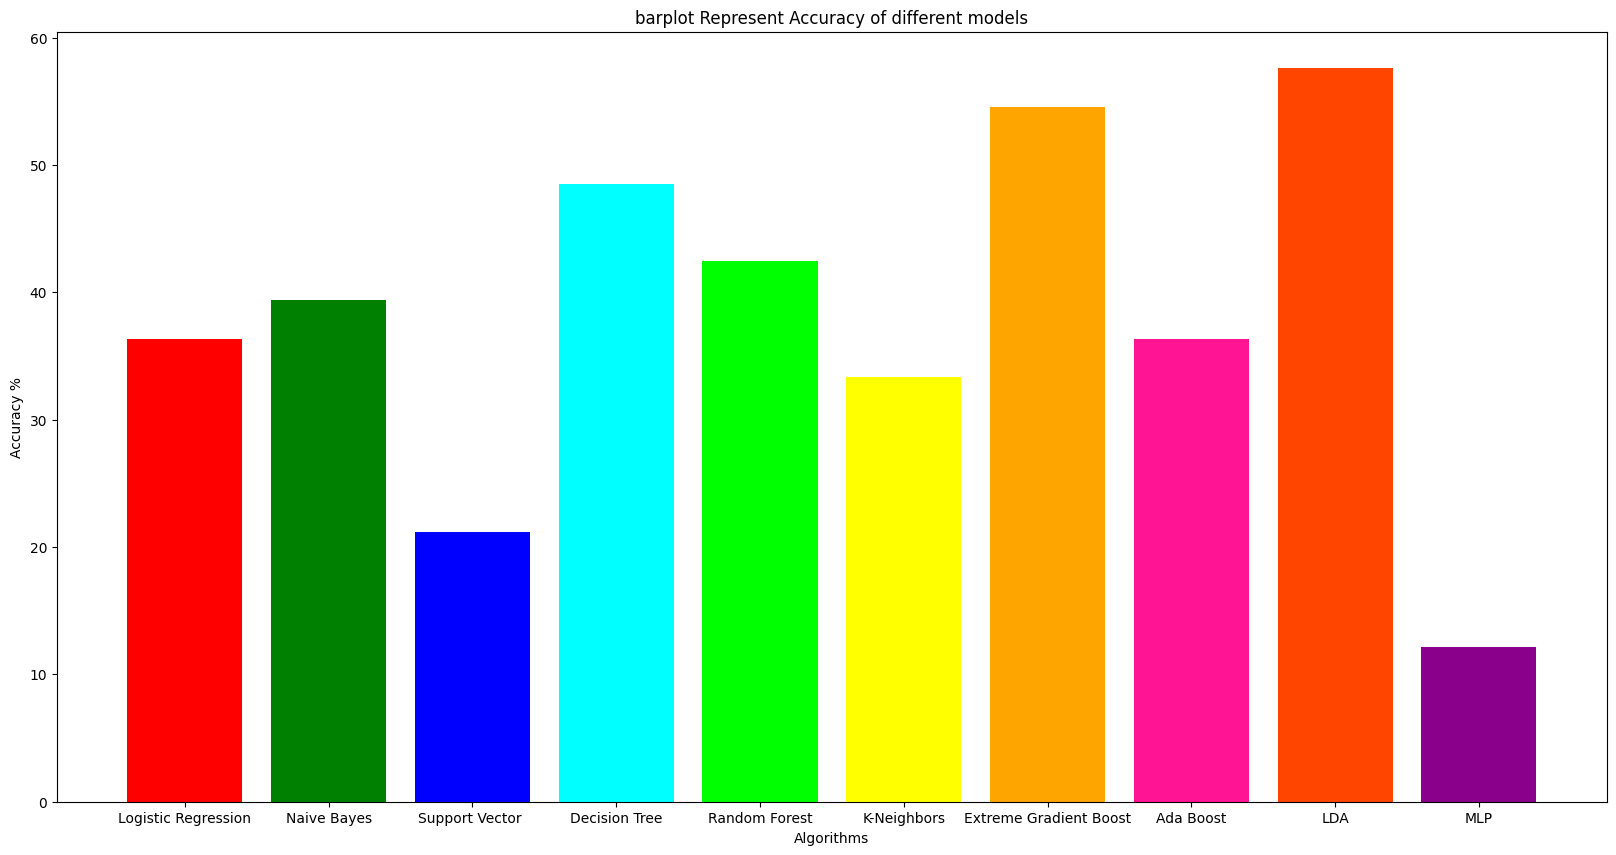

[                    Model   Accuracy
 0     Logistic Regression  36.363636
 1             Naive Bayes  39.393939
 2         Support Vector   21.212121
 3           Decision Tree  48.484848
 4           Random Forest  42.424242
 5             K-Neighbors  33.333333
 6  Extreme Gradient Boost  54.545455
 7               Ada Boost  36.363636
 8                     LDA  57.575758
 9                     MLP  12.121212,
 {'Logistic Regression': LogisticRegression(max_iter=5000),
  'Naive Bayes': GaussianNB(var_smoothing=1e-18),
  'Support Vector ': SVC(C=2),
  'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=32, random_state=0),
  'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=26, random_state=2),
  'K-Neighbors': KNeighborsClassifier(n_neighbors=16),
  'Extreme Gradient Boost': XGBClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.6,
                early_stoppi

In [18]:
data = filtermultiColumn(dataFrame,list(dataFrame.columns[:-1]))
Main(data,dataFrame.columns[:-1])

# feature_selection SequentialFeatureSelector

In [19]:
from sklearn.svm import SVR
from sklearn.feature_selection import SequentialFeatureSelector

y, X = dataFrame['label'], dataFrame.drop(columns='label').astype('float64')


knn = KNeighborsClassifier(n_neighbors=10)
sfs = SequentialFeatureSelector(knn, n_features_to_select=10)
sfs.fit(X, y)
selected_features = list(X.columns[sfs.get_support()])
selected_features

['PeakFrequency',
 'MNP',
 'TTP',
 'SM2',
 'SM3',
 'PSR',
 'MAV',
 'WL',
 'WAMP',
 'SSC']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


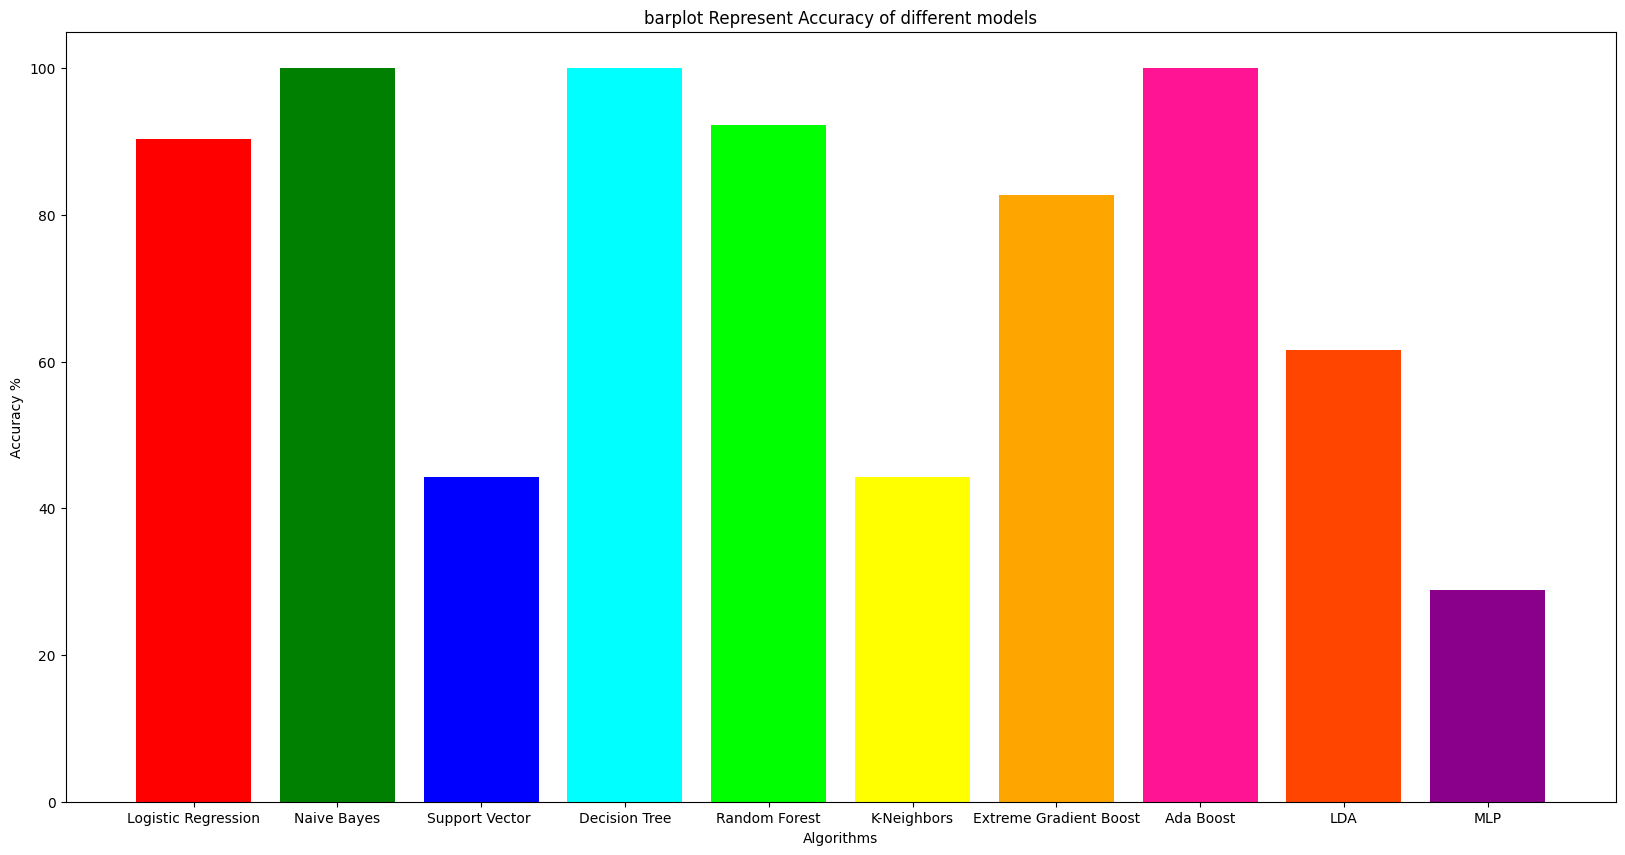

[                    Model    Accuracy
 0     Logistic Regression   90.384615
 1             Naive Bayes  100.000000
 2         Support Vector    44.230769
 3           Decision Tree  100.000000
 4           Random Forest   92.307692
 5             K-Neighbors   44.230769
 6  Extreme Gradient Boost   82.692308
 7               Ada Boost  100.000000
 8                     LDA   61.538462
 9                     MLP   28.846154,
 {'Logistic Regression': LogisticRegression(max_iter=5000),
  'Naive Bayes': GaussianNB(var_smoothing=1e-18),
  'Support Vector ': SVC(C=2),
  'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=32, random_state=0),
  'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=26, random_state=2),
  'K-Neighbors': KNeighborsClassifier(n_neighbors=16),
  'Extreme Gradient Boost': XGBClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.6,
                e

In [20]:
data1 = filtermultiColumn(dataFrame,selected_features)
Main(data1,selected_features)

# feature selection RFECV

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
y, X = dataFrame['label'], dataFrame.drop(columns='label').astype('float64')
estimator =LogisticRegression()

selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)

selected_features2 = list(X.columns[selector.support_])


In [22]:
selected_features2

['RMS',
 'WL',
 'AAC',
 'DASDV',
 'WAMP',
 'SSC',
 'MAVSLPk1',
 'MAVSLPk2',
 'MAVSLPk3']

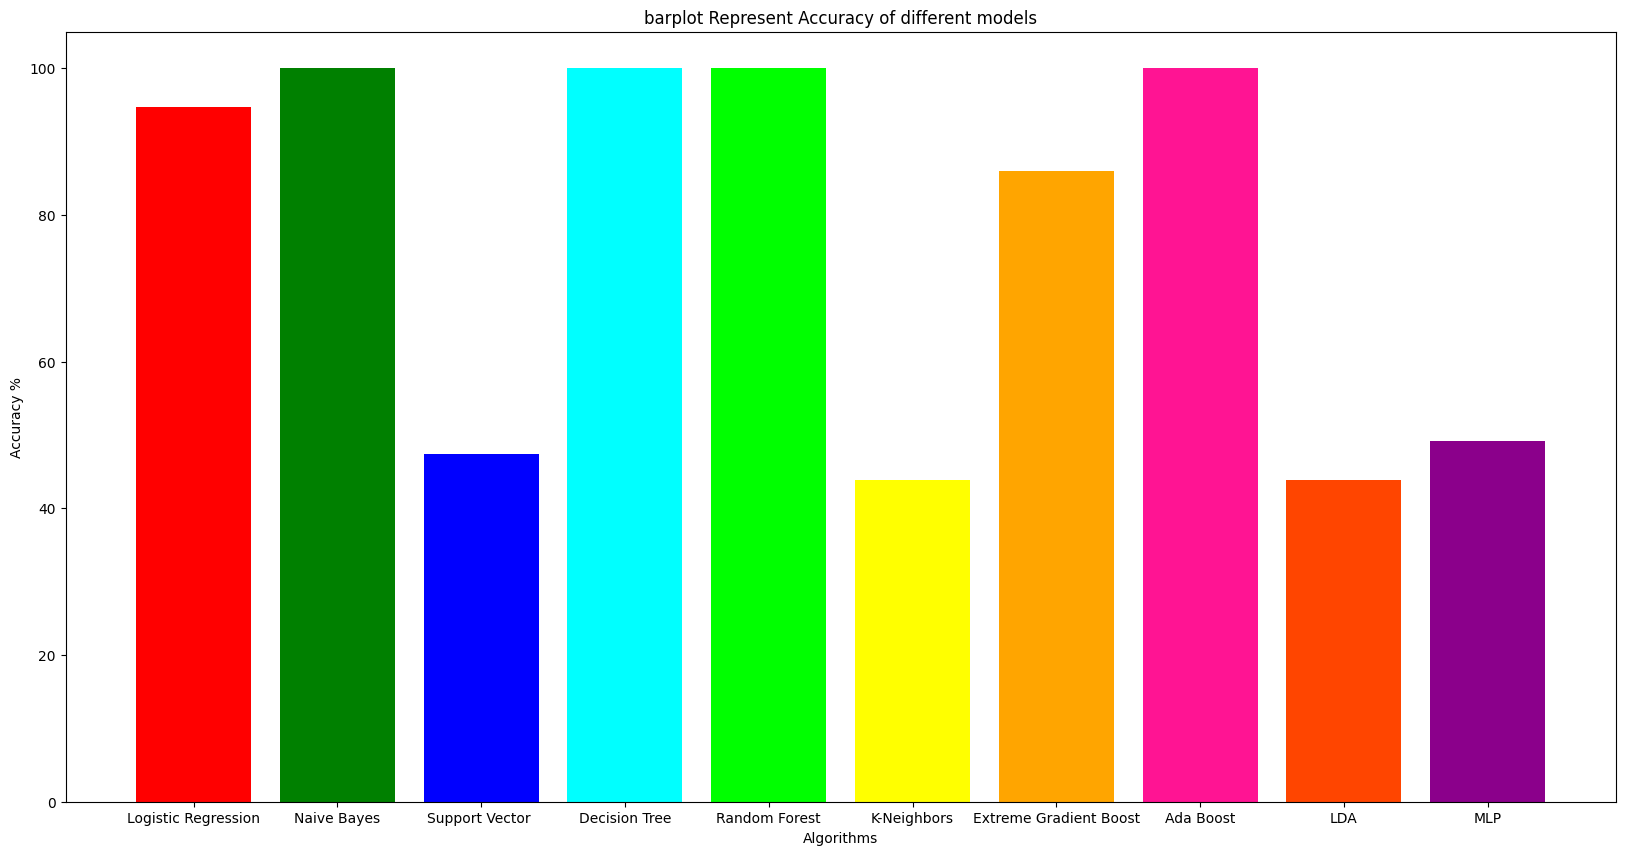

[                    Model    Accuracy
 0     Logistic Regression   94.736842
 1             Naive Bayes  100.000000
 2         Support Vector    47.368421
 3           Decision Tree  100.000000
 4           Random Forest  100.000000
 5             K-Neighbors   43.859649
 6  Extreme Gradient Boost   85.964912
 7               Ada Boost  100.000000
 8                     LDA   43.859649
 9                     MLP   49.122807,
 {'Logistic Regression': LogisticRegression(max_iter=5000),
  'Naive Bayes': GaussianNB(var_smoothing=1e-18),
  'Support Vector ': SVC(C=2),
  'Decision Tree': DecisionTreeClassifier(criterion='entropy', max_depth=32, random_state=0),
  'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=26, random_state=2),
  'K-Neighbors': KNeighborsClassifier(n_neighbors=16),
  'Extreme Gradient Boost': XGBClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.6,
                e

In [23]:
data2 = filtermultiColumn(dataFrame,selected_features2)
Main(data2,selected_features2)